## We have a very big imbalance in our dataset

We want to oversample, but this the approach will be different then with basic tabular features.

Let's take a more normal tabular based set of features with a binary label.  If there is an imbalance between the two targets, we want to overrepresent the miniority class.  But this is not that simple.  If I take just one row and replicate it n times, I would get the balance I want.  But the feature values in this single sample would skew the learning to favor that sample's features.

So with classic features, we want to use something like SMOTE to syntheticly create new rows that look like our actual observations.  SMOTE takes each of the miniority class and radomily picks n of the k nearest neighbors as the synthetic row. For each of the n randomly picked neighbors, SMOTE creates new set of features by randomly interpolated the values on a vector between the sample and the chosen neighbor.

If we transfered this approach to our x-ray dataset, we would take each image from the miniority class and randomly pick n of the k nearest neighbors and randomly interpolate a new image that would be a "meld" of the 2 existing x-rays..  These n new derived x-rays would get inserted in our oversampled dataset.

Obvisously, we cannot do this with images.  We have not method of melding 2 images together in any way that would mimic a clinical image.  We also cannot find a logical metric to determine closeness between 2 x-rays.

But we do have multi-label targets.  We can randomly pick n x-rays with the same target vector and insert (duplicate) these x-rays into our oversampled dataset.


In [1]:
import sys
import os, os.path

sys.path.append(os.path.join(os.getcwd() ,'/modules'))
root_path = "C:/git/Springboard-Public/Capstone Project 2/"
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    root_path = "/content/drive/My Drive/Capstone Project 2/"

print('Current Working Dir: ', os.getcwd())
print('Root Path: ', root_path)

# We need to set the working directory since we are using relative paths from various locations
if os.getcwd() != root_path:
  os.chdir(root_path)

Current Working Dir:  C:\git\Springboard-Public\Capstone Project 2\notebooks\Support Notebooks for Modules
Root Path:  C:/git/Springboard-Public/Capstone Project 2/


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from modules.lib.CheXpertData import *

%matplotlib inline

In [3]:
force_cpu = True
device = torch.device('cuda' if ~force_cpu and torch.cuda.is_available() else 'cpu')
# Assume that we are on a CUDA machine, then this should print a CUDA device:
print(f'Working on device={device}')

Working on device=cuda


## Hist of number of positive targets

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000017CFED6AF08>]],
      dtype=object)

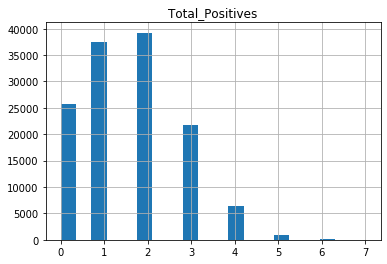

In [4]:
metaData = CleanMetaData()
df_clean = metaData.getCleanDF()
target_columns = metaData.target_columns
target_columns_plus = target_columns.copy()
df_clean['Total_Positives'] = df_clean[target_columns].sum(axis=1)
target_columns_plus.append('Total_Positives')
df_clean.hist('Total_Positives', bins=20)

## Distribution of target vectors

We could just do a groupby on the 12 columns, but doing concat makes it easier to visulize.

In [5]:
total_rows = df_clean.shape[0]
df_combined = pd.DataFrame(df_clean.PatientID)
df_combined['Combined_Targets'] = ''
for c in target_columns:
    df_combined['Combined_Targets'] = df_combined['Combined_Targets'] + df_clean[c].map({-1:'N', 0:'0', 1:'P'})
   
df_combinations = pd.DataFrame(df_combined.groupby(['Combined_Targets']).count())
df_combinations.columns = ['Frequency']
df_combinations['Percent'] = df_combinations.Frequency / total_rows
print(f'Total Unique Target Combinations {df_combinations.shape[0]:,}')
df_combinations = df_combinations.sort_values(['Frequency'], ascending=False)
print(target_columns)
display(df_combinations)

Total Unique Target Combinations 802
['Enlarged_Cardiomediastinum', 'Cardiomegaly', 'Lung_Opacity', 'Lung_Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural_Effusion', 'Pleural_Other', 'Fracture']


,Frequency,Percent
Combined_Targets,,
000000000000,25805,0.195866
00P000000000,12816,0.097277
00P000000P00,10586,0.080350
0000P0000000,4834,0.036691
000000000P00,4770,0.036205
...,...,...
0P0000P000P0,1,0.000008
0P0000P0000P,1,0.000008
P00P0P000000,1,0.000008


In [6]:
df_combinations_und = df_combinations[df_combinations.Percent < 0.01]
underrepresented_rows = df_combinations_und.shape[0]
print(f'Number of underrepresented combinations: {underrepresented_rows:,} (\
{float(underrepresented_rows) / float(total_rows*100):.2%})')

Number of underrepresented combinations: 782 (0.01%)


In [7]:
# simply append the combination of underrep to our origional df
df_clean['Combined_Targets'] = df_combined['Combined_Targets'] 
target_columns_plus.append('Combined_Targets')
df_clean[target_columns_plus]

,Enlarged_Cardiomediastinum,Cardiomegaly,Lung_Opacity,Lung_Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural_Effusion,Pleural_Other,Fracture,Total_Positives,Combined_Targets
ImageID,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,000000000000
1,0,0,1,0,0,0,0,0,0,0,0,1,2,00P00000000P
2,0,0,1,0,0,0,0,0,0,0,0,1,2,00P00000000P
4,0,0,0,0,1,0,0,0,0,0,0,0,1,0000P0000000
5,0,0,0,0,0,0,0,0,0,0,0,0,0,000000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223409,0,0,0,0,0,0,0,0,0,1,0,0,1,000000000P00
223410,0,0,0,0,0,0,0,0,0,0,0,0,0,000000000000
223411,0,0,0,0,0,0,0,0,0,0,0,0,0,000000000000


In [8]:
df_underrep = df_clean[df_clean.Combined_Targets.isin(df_combinations_und.index)]
df_underrep[target_columns_plus]

,Enlarged_Cardiomediastinum,Cardiomegaly,Lung_Opacity,Lung_Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural_Effusion,Pleural_Other,Fracture,Total_Positives,Combined_Targets
ImageID,,,,,,,,,,,,,,
1,0,0,1,0,0,0,0,0,0,0,0,1,2,00P00000000P
2,0,0,1,0,0,0,0,0,0,0,0,1,2,00P00000000P
12,0,1,1,0,0,0,0,1,1,0,0,0,4,0PP0000PP000
13,1,0,1,0,0,0,0,1,0,0,0,0,3,P0P0000P0000
16,0,1,0,0,0,0,0,1,0,0,0,0,2,0P00000P0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223397,0,0,0,0,1,0,0,1,0,1,0,0,3,0000P00P0P00
223401,0,0,1,1,0,0,0,0,1,1,0,0,4,00PP0000PP00
223403,0,1,0,0,1,0,0,0,0,1,0,0,3,0P00P0000P00


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000017C86012608>]],
      dtype=object)

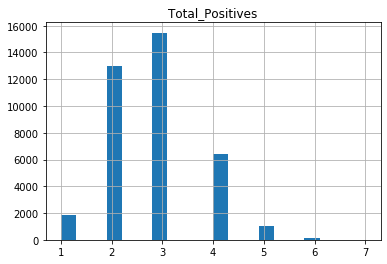

In [9]:
df_underrep.hist('Total_Positives', bins=20)

In [10]:
df_clean_oversample = df_clean.append(df_underrep)
df_clean_oversample

,PatientID,StudyID,Age,Sex_Male,Sex_Unknown,Orientation_PA,Support Devices,Image_Path,Hierarchical_Path,Enlarged_Cardiomediastinum,...,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural_Effusion,Pleural_Other,Fracture,Total_Positives,Combined_Targets
ImageID,,,,,,,,,,,,,,,,,,,,,
0,1,1,68,0,0,0,1.0,data/raw/train/patient00001/study1/view1_front...,data/d0/d1/i0.jpg,0,...,0,0,0,0,0,0,0,0,0,000000000000
1,2,2,87,0,0,0,0.0,data/raw/train/patient00002/study2/view1_front...,data/d1/d2/i1.jpg,0,...,0,0,0,0,0,0,0,1,2,00P00000000P
2,2,1,83,0,0,0,0.0,data/raw/train/patient00002/study1/view1_front...,data/d2/d2/i2.jpg,0,...,0,0,0,0,0,0,0,1,2,00P00000000P
4,3,1,41,1,0,0,0.0,data/raw/train/patient00003/study1/view1_front...,data/d4/d3/i4.jpg,0,...,1,0,0,0,0,0,0,0,1,0000P0000000
5,4,1,20,0,0,1,0.0,data/raw/train/patient00004/study1/view1_front...,data/d5/d4/i5.jpg,0,...,0,0,0,0,0,0,0,0,0,000000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223397,64527,1,85,1,0,0,1.0,data/raw/train/patient64527/study1/view1_front...,data/d47/d27/i223397.jpg,0,...,1,0,0,1,0,1,0,0,3,0000P00P0P00
223401,64531,1,57,0,0,0,1.0,data/raw/train/patient64531/study1/view1_front...,data/d1/d31/i223401.jpg,0,...,0,0,0,0,1,1,0,0,4,00PP0000PP00
223403,64533,1,75,1,0,0,1.0,data/raw/train/patient64533/study1/view1_front...,data/d3/d33/i223403.jpg,0,...,1,0,0,0,0,1,0,0,3,0P00P0000P00


## First attempt to build the oversample method

In [11]:
metaData = CleanMetaData()
df_clean = metaData.getCleanDF()
target_columns = metaData.target_columns

In [12]:
def oversampleDF1(df, combination_percent = 0.01, oversample_factor = 3):
    df_combined = pd.DataFrame(df.index) #builds a new df with the same index as df (same row count)
    total_rows = df_combined.shape[0]
    
    # Let's do this via concatenation instead of a groupby
    # This give us an easier way to see the combination without spaning multiple columns
    df_combined['Combined_Targets'] = ''
    for c in target_columns:
        df_combined['Combined_Targets'] = df_combined['Combined_Targets'] + df[c].map({-1:'N', 0:'0', 1:'P'})

    # Now do the groupby on the concatenated column
    # Remember, df_combined has the same cardinality as the passed in df
    df_combinations = pd.DataFrame(df_combined.groupby(['Combined_Targets']).count() / total_rows)
    df_combinations.columns = ['Percent']

    # We only want the combinations that have less rows than the percent passed in
    df_combinations_und = df_combinations[df_combinations.Percent < combination_percent]

    # Use above result to filter passed in df
    df['Combined_Targets'] = df_combined['Combined_Targets'].copy()
    df_underrep = df[df.Combined_Targets.isin(df_combinations_und.index)].copy()
    df_underrep['Oversampled'] = 1
    underrep_count = df_underrep.shape[0]

    # Let's leave the passed in df alone so we do a copy
    df_oversample = df.copy()
    df_oversample['Oversampled'] = 0
    
    # We simply dup the underrepresented into df_oversample (as many times as instructed)
    underrep_count = len(df_underrep)
    new_index_values = np.linspace(1, underrep_count, underrep_count) * -1
    for i in range(1, oversample_factor):
        df_loop = df_underrep.copy()
        df_loop.index = new_index_values
        df_oversample = df_oversample.append(df_loop)
        new_index_values -= underrep_count

    df_oversample = df_oversample.sort_index()
    
    return (df_oversample, underrep_count, underrep_count * oversample_factor)

In [13]:
df_oversample, underrep_count, total_rows_added = oversampleDF1(df_clean, oversample_factor=3)
print(f'Total Oversampled Rows Added: {total_rows_added:,}\n')
    
index_values = df_oversample.index.to_numpy()
print(f'Total Rows: {len(index_values):,}')
print(f'Unique ImageID Count: {len(set(index_values)):,}')
                               
combined_target_counts = df_oversample.groupby('Combined_Targets').Combined_Targets.count()
display(combined_target_counts.sort_values().head(10))
df_oversample

Total Oversampled Rows Added: 87,723

Total Rows: 190,230
Unique ImageID Count: 190,230


Combined_Targets
0P000P0000P0    3
0PP0000P0PP0    3
0PP0000P00PP    3
0PP0000P000P    3
0PP00000PP0P    3
0PP00000P00P    3
0P0PPPP00000    3
0P0PPP000000    3
0P0PP00P0000    3
0P0P0P000P0P    3
Name: Combined_Targets, dtype: int64

,PatientID,StudyID,Age,Sex_Male,Sex_Unknown,Orientation_PA,Support Devices,Image_Path,Hierarchical_Path,Enlarged_Cardiomediastinum,...,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural_Effusion,Pleural_Other,Fracture,Combined_Targets,Oversampled
-58482.0,31557,1,71,0,0,1,0.0,data/raw/train/patient31557/study1/view1_front...,data/d42/d7/i131742.jpg,0,...,0,0,0,1,0,1,0,0,0000000P0P00,1
-58481.0,31556,3,71,1,0,0,1.0,data/raw/train/patient31556/study3/view1_front...,data/d39/d6/i131739.jpg,0,...,1,0,0,1,0,0,0,0,0000P00P0000,1
-58480.0,31556,4,71,1,0,0,1.0,data/raw/train/patient31556/study4/view1_front...,data/d37/d6/i131737.jpg,0,...,1,0,0,1,0,0,0,0,0000P00P0000,1
-58479.0,31554,3,28,1,0,0,1.0,data/raw/train/patient31554/study3/view1_front...,data/d29/d4/i131729.jpg,0,...,1,0,0,0,0,0,0,0,0P00P0000000,1
-58478.0,31551,1,48,1,0,0,0.0,data/raw/train/patient31551/study1/view1_front...,data/d13/d1/i131713.jpg,0,...,0,0,0,0,0,0,0,1,00000000000P,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223409.0,64537,2,59,1,0,0,0.0,data/raw/train/patient64537/study2/view1_front...,data/d9/d37/i223409.jpg,0,...,0,0,0,0,0,1,0,0,NaN,0
223410.0,64537,1,59,1,0,0,0.0,data/raw/train/patient64537/study1/view1_front...,data/d10/d37/i223410.jpg,0,...,0,0,0,0,0,0,0,0,NaN,0
223411.0,64538,1,0,0,0,0,0.0,data/raw/train/patient64538/study1/view1_front...,data/d11/d38/i223411.jpg,0,...,0,0,0,0,0,0,0,0,NaN,0
223412.0,64539,1,0,0,0,0,0.0,data/raw/train/patient64539/study1/view1_front...,data/d12/d39/i223412.jpg,0,...,0,0,0,1,0,0,0,0,NaN,0


## Second attempt

We need to fill closer to the desired min count. 

In [14]:
def oversampleDF2(df, observation_min_count = 50, group_interval = 5):
    df_combined = pd.DataFrame(df.index) #builds a new df with the same index as df (same row count)
    total_rows = df_combined.shape[0]
    
    # Let's do this via concatenation instead of a groupby
    # This give us an easier way to see the combination without spaning multiple columns
    df_combined['Combined_Targets'] = ''
    for c in target_columns:
        df_combined['Combined_Targets'] = df_combined['Combined_Targets'] + df[c].map({-1:'N', 0:'0', 1:'P'})

    # Now do the groupby on the concatenated column
    # Remember, df_combined has the same cardinality as the passed in df
    df_combinations = pd.DataFrame(df_combined.groupby(['Combined_Targets']).count().astype('float'))
    df_combinations.columns = ['Observations']

    # We only want the combinations that have less rows than the threshold
    df_combinations_und = df_combinations[df_combinations.Observations < observation_min_count].copy()
    df_combinations_und['AddCount'] = np.ceil(observation_min_count / df_combinations_und.Observations).astype('int')
    add_counts = set(df_combinations_und.AddCount)
    
    # Use above result to filter passed in df
    df_in = df.copy()
    df_in['Combined_Targets'] = df_combined['Combined_Targets'].copy()
    df_underrep = df_in[df_in.Combined_Targets.isin(df_combinations_und.index)].copy()
    
    # Let's leave the passed in df alone so we do a copy
    df_oversample = df.copy()
    df_dup_rows = df.iloc[0:0,:].copy()
    
    # We simply dup the underrepresented into df_oversample
    for add_count in add_counts:
        combinations_in_group = df_combinations_und[df_combinations_und.AddCount==add_count].index
        rows_to_copy = df_underrep[df_underrep.Combined_Targets.isin(combinations_in_group)].copy()
        for rep in range(add_count):
            df_dup_rows = df_dup_rows.append(rows_to_copy.copy(), sort=False)
    
    dup_row_count = len(df_dup_rows)
    new_index_values = np.linspace(1, dup_row_count, dup_row_count) * -1
    df_dup_rows.index = new_index_values
    
    df_oversample = df_oversample.append(df_dup_rows, sort=False)
    df_oversample = df_oversample.sort_index()
    
    return (df_oversample, len(df_dup_rows))

In [15]:
df_oversample, total_rows_added = oversampleDF2(df_clean, observation_min_count=22)
print(f'Total Oversampled Rows Added: {total_rows_added:,}\n')
    
index_values = df_oversample.index.to_numpy()
print(f'Total Rows: {len(index_values):,}')
print(f'Unique ImageID Count: {len(set(index_values)):,}')
                               
combined_target_counts = df_oversample.groupby('Combined_Targets').Combined_Targets.count()
display(combined_target_counts.sort_values().head(10))
df_oversample

Total Oversampled Rows Added: 12,012

Total Rows: 143,760
Unique ImageID Count: 143,760


Combined_Targets
00P00P00P000    22
00PP0000PP00    22
0P000P0000P0    23
0PP0000PPP00    23
0PP0000P0PP0    23
0PP0000P00PP    23
0PP0000P000P    23
0PP00000PP0P    23
0PP00000P00P    23
0P0PPPP00000    23
Name: Combined_Targets, dtype: int64

,PatientID,StudyID,Age,Sex_Male,Sex_Unknown,Orientation_PA,Support Devices,Image_Path,Hierarchical_Path,Enlarged_Cardiomediastinum,...,Lung_Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural_Effusion,Pleural_Other,Fracture,Combined_Targets
-12012.0,31231,1,90,1,0,0,0.0,data/raw/train/patient31231/study1/view1_front...,data/d2/d31/i130402.jpg,0,...,1,0,0,0,1,0,0,0,1,00PP000P000P
-12011.0,31165,1,46,0,0,0,0.0,data/raw/train/patient31165/study1/view1_front...,data/d0/d15/i130150.jpg,1,...,1,1,0,0,0,0,1,0,0,P00PP0000P00
-12010.0,31048,1,57,0,0,0,0.0,data/raw/train/patient31048/study1/view1_front...,data/d13/d48/i129613.jpg,0,...,1,1,0,0,1,0,0,1,0,00PPP00P00P0
-12009.0,31025,3,40,1,0,0,1.0,data/raw/train/patient31025/study3/view1_front...,data/d36/d25/i129536.jpg,1,...,0,1,0,1,0,0,1,0,0,P0P0P0P00P00
-12008.0,30852,1,54,1,0,0,0.0,data/raw/train/patient30852/study1/view1_front...,data/d2/d2/i128852.jpg,0,...,1,0,0,0,1,1,0,0,1,000P000PP00P
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223409.0,64537,2,59,1,0,0,0.0,data/raw/train/patient64537/study2/view1_front...,data/d9/d37/i223409.jpg,0,...,0,0,0,0,0,0,1,0,0,NaN
223410.0,64537,1,59,1,0,0,0.0,data/raw/train/patient64537/study1/view1_front...,data/d10/d37/i223410.jpg,0,...,0,0,0,0,0,0,0,0,0,NaN
223411.0,64538,1,0,0,0,0,0.0,data/raw/train/patient64538/study1/view1_front...,data/d11/d38/i223411.jpg,0,...,0,0,0,0,0,0,0,0,0,NaN
223412.0,64539,1,0,0,0,0,0.0,data/raw/train/patient64539/study1/view1_front...,data/d12/d39/i223412.jpg,0,...,0,0,0,0,1,0,0,0,0,NaN


### Attemp 3, fill to exact par level using randomly picked rows with replacement

In [16]:
def oversampleDF3(df, observation_min_count = 50):
    df_combined = pd.DataFrame(df.index) #builds a new df with the same index as df (same row count)
    total_rows = df_combined.shape[0]
    
    # Let's do this via concatenation instead of a groupby
    # This give us an easier way to see the combination without spaning multiple columns
    df_combined['Combined_Targets'] = ''
    for c in target_columns:
        df_combined['Combined_Targets'] = df_combined['Combined_Targets'] + df[c].map({-1:'N', 0:'0', 1:'P'})

    # Now do the groupby on the concatenated column
    # Remember, df_combined has the same cardinality as the passed in df
    df_combinations = pd.DataFrame(df_combined.groupby(['Combined_Targets']).count().astype('float'))
    df_combinations.columns = ['Observations']

    # We only want the combinations that have less rows than the threshold
    df_combinations_und = df_combinations[df_combinations.Observations < observation_min_count].copy()
    df_combinations_und['AddCount'] = (observation_min_count - df_combinations_und.Observations).astype('int')
    
    # Use above result to filter passed in df
    df_in = df.copy()
    df_in['Combined_Targets'] = df_combined['Combined_Targets'].copy()
    df_underrep = df_in[df_in.Combined_Targets.isin(df_combinations_und.index)].copy()
    
    # Let's leave the passed in df alone so we do a copy
    df_oversample = df.copy()
    df_dup_rows = df.iloc[0:0,:].copy()
    
    # Walk every combination with a deficit
    # Randomly pick rows with the same combination
    # Insert these random rows to fill in deficit
    combinations_with_deficit = df_combinations_und[df_combinations_und.AddCount>0].AddCount
    for combination, add_count in combinations_with_deficit.items():
        rows_to_copy = df_underrep[df_underrep.Combined_Targets==combination] \
                        .sample(add_count, replace=True).copy()
        df_dup_rows = df_dup_rows.append(rows_to_copy.copy(), sort=False)
    
    # We need to unique index for these rows
    # Let's make them negative so that we know they are oversample rows
    dup_row_count = len(df_dup_rows)
    new_index_values = np.linspace(1, dup_row_count, dup_row_count) * -1
    df_dup_rows.index = new_index_values
    
    # Append the dup rows into the oversample df
    df_oversample = df_oversample.append(df_dup_rows, sort=False)
    df_oversample = df_oversample.sort_index()
    
    return (df_oversample, len(df_dup_rows))

In [17]:
df_oversample, total_rows_added = oversampleDF3(df_clean, observation_min_count=22)
print(f'Total Oversampled Rows Added: {total_rows_added:,}\n')
    
index_values = df_oversample.index.to_numpy()
print(f'Total Rows: {len(index_values):,}')
print(f'Unique ImageID Count: {len(set(index_values)):,}')
                               
combined_target_counts = df_oversample.groupby('Combined_Targets').Combined_Targets.count()
display(combined_target_counts.sort_values().head(10))
df_oversample

Total Oversampled Rows Added: 8,897

Total Rows: 140,645
Unique ImageID Count: 140,645


Combined_Targets
0P000P0000P0    22
0PP0P000000P    22
0PP0P00000P0    22
0PP0P0000P0P    22
0PP0P0000PP0    22
0PP0P000P000    22
0PP0P000PP00    22
0PP00PPP0P00    22
0PP0P00P000P    22
0PP0P00PP000    22
Name: Combined_Targets, dtype: int64

,PatientID,StudyID,Age,Sex_Male,Sex_Unknown,Orientation_PA,Support Devices,Image_Path,Hierarchical_Path,Enlarged_Cardiomediastinum,...,Lung_Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural_Effusion,Pleural_Other,Fracture,Combined_Targets
-8897.0,16888,1,55,1,0,1,0.0,data/raw/train/patient16888/study1/view1_front...,data/d2/d38/i70452.jpg,1,...,1,1,0,1,0,0,1,0,0,PPPPP0P00P00
-8896.0,16888,1,55,1,0,1,0.0,data/raw/train/patient16888/study1/view1_front...,data/d2/d38/i70452.jpg,1,...,1,1,0,1,0,0,1,0,0,PPPPP0P00P00
-8895.0,16888,1,55,1,0,1,0.0,data/raw/train/patient16888/study1/view1_front...,data/d2/d38/i70452.jpg,1,...,1,1,0,1,0,0,1,0,0,PPPPP0P00P00
-8894.0,16888,1,55,1,0,1,0.0,data/raw/train/patient16888/study1/view1_front...,data/d2/d38/i70452.jpg,1,...,1,1,0,1,0,0,1,0,0,PPPPP0P00P00
-8893.0,16888,1,55,1,0,1,0.0,data/raw/train/patient16888/study1/view1_front...,data/d2/d38/i70452.jpg,1,...,1,1,0,1,0,0,1,0,0,PPPPP0P00P00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223409.0,64537,2,59,1,0,0,0.0,data/raw/train/patient64537/study2/view1_front...,data/d9/d37/i223409.jpg,0,...,0,0,0,0,0,0,1,0,0,NaN
223410.0,64537,1,59,1,0,0,0.0,data/raw/train/patient64537/study1/view1_front...,data/d10/d37/i223410.jpg,0,...,0,0,0,0,0,0,0,0,0,NaN
223411.0,64538,1,0,0,0,0,0.0,data/raw/train/patient64538/study1/view1_front...,data/d11/d38/i223411.jpg,0,...,0,0,0,0,0,0,0,0,0,NaN
223412.0,64539,1,0,0,0,0,0.0,data/raw/train/patient64539/study1/view1_front...,data/d12/d39/i223412.jpg,0,...,0,0,0,0,1,0,0,0,0,NaN
